In [2]:
import os
import kagglehub
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as fun

import torchvision
import torchvision.transforms as transforms

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("kapillondhe/american-sign-language")
path += '\\ASL_Dataset'
print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\kapillondhe\american-sign-language\versions\1\ASL_Dataset


# EDA

In [81]:
def get_paths(root: str, n: int) -> list[str]:
    paths = list()
    dont_stop = (n == -1)
    labels = os.listdir(root)
    for label in labels:
        for imgname in os.listdir(f'{root}\\{label}'):
            paths.append(f'{root}\\{label}\\{imgname}')
            n -= 1
            if not dont_stop and n < 0:
                break
            
        if not dont_stop and n < 0:
            break
        
    return paths

### Data distribution

In [ ]:
def data_balance(root: str) -> dict[str, int]:
    labels = set()
    count_of_labels = dict()
    
    for data_class in os.listdir(root):
        labels.add(data_class)
    
    for label in labels:
        count_of_labels[label] = len(os.listdir(f'{root}\\{label}')) 
    
    return count_of_labels 

C:\Users\User\AppData\Local\Temp\ipykernel_22124\911180666.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


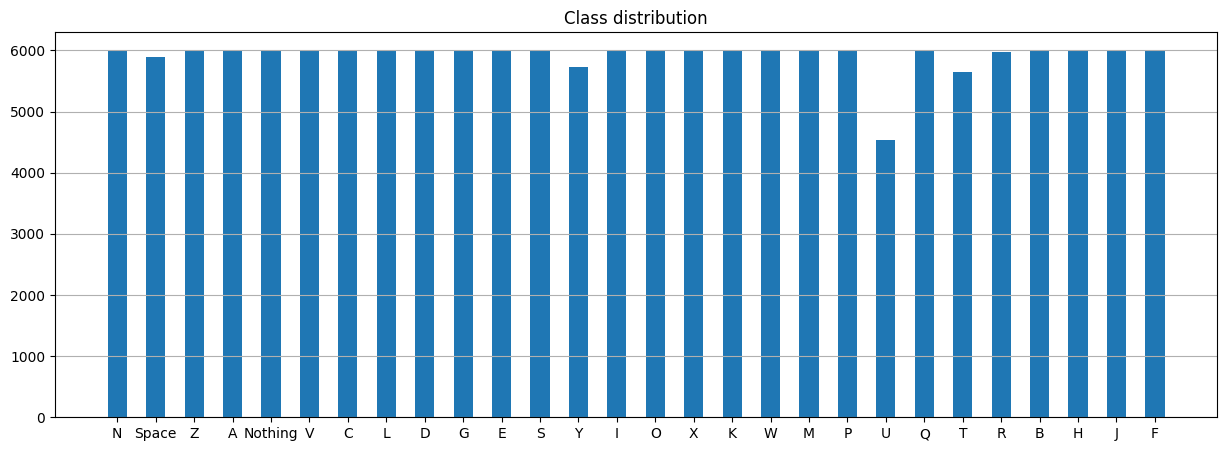

In [80]:
count = data_balance(f'{path}\\Train')
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Class distribution")
ax.grid(True, 'major', 'y')
ax.bar(list(count.keys()), list(count.values()), align='center', width=0.5)
fig.show()

### Image resolutions

In [82]:
def resolutions(root) -> set[tuple[int, int]]:
    paths = get_paths(root, -1)  
    resolutions = set()
    for imgpath in paths:
        img = Image.open(imgpath)
        resolutions.add(img.size)
        
    return resolutions

In [84]:
print(f'Resolutions in training set: {resolutions(f'{path}\\Train')}')
print(f'Resolutions in evaluation set: {resolutions(f'{path}\\Test')}')

Resolutions in training set: {(400, 400)}
Resolutions in evaluation set: {(400, 400)}


### Corrupted images

In [91]:
def corrupted(root) -> list:
    corrupted = list()
    paths = get_paths(root, 2000)  

    for p in paths:
        try:
            Image.open(p).verify()
        except:
            corrupted.append(p)
    
    return corrupted

In [92]:
train_corrupted = corrupted(f'{path}\\Train')
test_corrupted = corrupted(f'{path}\\Test')

print(f'Count of corrupted images in training set: {len(train_corrupted)} ({train_corrupted})')
print(f'Count of corrupted images in evaluating set: {len(test_corrupted)} ({test_corrupted})')

Count of corrupted images in training set: 0 ([])
Count of corrupted images in evaluating set: 0 ([])


### Color channels
 

In [108]:
def get_channels(root: str) -> set[str]:
    paths = get_paths(root, 2000)
    channels = set()
    
    for p in paths:
        img = Image.open(p)
        channels.add(img.getbands())
        
    return channels

In [109]:
train_channels = get_channels(f'{path}\\Train')
test_channels = get_channels(f'{path}\\Test')

print(f'Count of color schemas in training set: {len(train_channels)} ({train_channels})')
print(f'Count of color schemas in evaluating set: {len(test_channels)} ({test_channels})')

Count of color schemas in training set: 1 ({('R', 'G', 'B')})
Count of color schemas in evaluating set: 1 ({('R', 'G', 'B')})


### Pixel intensity

In [111]:
def get_average_intensities(root: str) -> list[float]:
    paths = get_paths(root, 1000)  
    intensities = list()
    for p in paths:
        img = Image.open(p).convert('L')
        intensities.append(float(np.mean(img)))
    
    return intensities

Training set
Mean: 138.328
Std: 5.469
Range (min - max): 126.454 - 148.097

Evaluating set
Mean: 133.674
Std: 6.519
Range (min - max): 119.47 - 150.227


C:\Users\User\AppData\Local\Temp\ipykernel_22124\4180944743.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


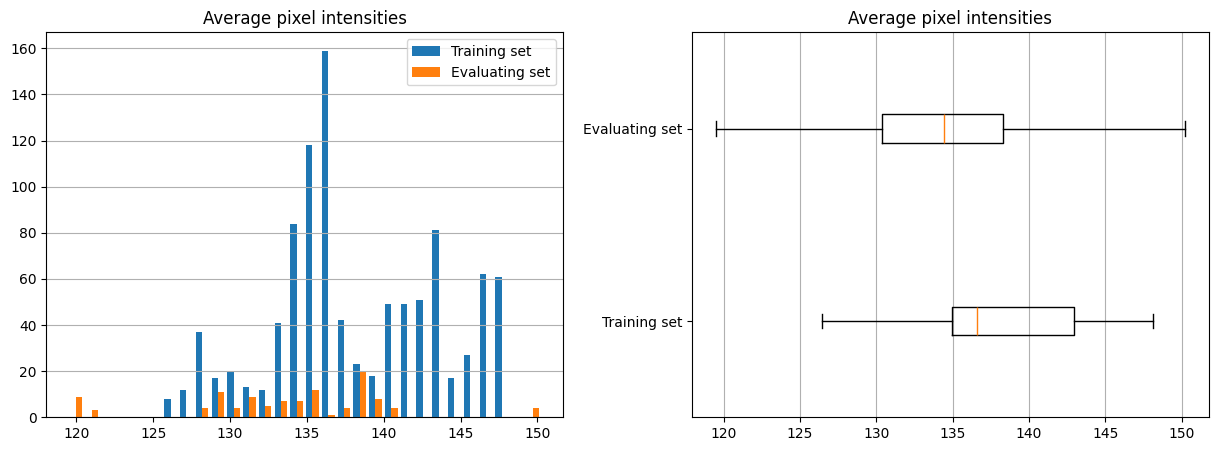

In [116]:
train_intensities = get_average_intensities(f'{path}\\Train')
test_intensities = get_average_intensities(f'{path}\\Test')

print('Training set')
print(f'Mean: {float(round(np.mean(train_intensities), 3))}') 
print(f'Std: {float(round(np.std(train_intensities), 3))}')
print(f'Range (min - max): {round(min(train_intensities), 3)} - {round(max(train_intensities), 3)}')
print()
print('Evaluating set')
print(f'Mean: {float(round(np.mean(test_intensities), 3))}') 
print(f'Std: {float(round(np.std(test_intensities), 3))}')
print(f'Range (min - max): {round(min(test_intensities), 3)} - {round(max(test_intensities), 3)}')

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Average pixel intensities")
ax1.grid(True, 'major', 'y')
ax1.hist([train_intensities, test_intensities], bins=30, label=['Training set', 'Evaluating set'])
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Average pixel intensities")
ax2.grid(True, 'both', 'x')
ax2.boxplot([train_intensities, test_intensities], orientation='horizontal', tick_labels=['Training set', 'Evaluating set'])

fig.subplots_adjust(wspace=0.25)
fig.show()

### Contrast

In [126]:
def get_contrasts(root: str) -> list[float]:
    paths = get_paths(root, 2000)  
    contrasts = list()
    for p in paths:
        img = Image.open(p).convert('L')
        arr = np.array(img, dtype=np.float32)
        min_l = arr.min()
        max_l = arr.max()

        if max_l + min_l == 0:
            contrasts.append(0.0)
        else:
            contrasts.append((max_l - min_l) / (max_l + min_l))   
        
    return contrasts    

Training set
Mean: 0.671999990940094
Std: 0.019999999552965164
Range (min - max): 0.6190000176429749 - 0.7590000033378601

Evaluating set
Mean: 0.6589999794960022
Std: 0.09399999678134918
Range (min - max): 0.210999995470047 - 0.7730000019073486


C:\Users\User\AppData\Local\Temp\ipykernel_22124\3982656717.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


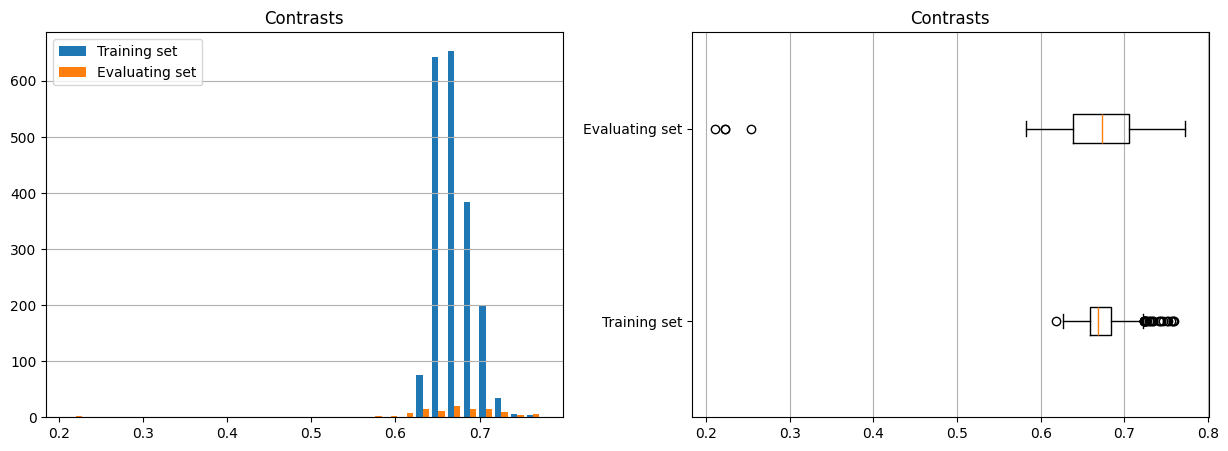

In [127]:
train_contrasts = get_contrasts(f'{path}\\Train')
test_contrasts = get_contrasts(f'{path}\\Test')

print('Training set')
print(f'Mean: {float(round(np.mean(train_contrasts), 3))}') 
print(f'Std: {float(round(np.std(train_contrasts), 3))}')
print(f'Range (min - max): {round(min(train_contrasts), 3)} - {round(max(train_contrasts), 3)}')
print()
print('Evaluating set')
print(f'Mean: {float(round(np.mean(test_contrasts), 3))}') 
print(f'Std: {float(round(np.std(test_contrasts), 3))}')
print(f'Range (min - max): {round(min(test_contrasts), 3)} - {round(max(test_contrasts), 3)}')

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Contrasts")
ax1.grid(True, 'major', 'y')
ax1.hist([train_contrasts, test_contrasts], bins=30, label=['Training set', 'Evaluating set'])
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Contrasts")
ax2.grid(True, 'both', 'x')
ax2.boxplot([train_contrasts, test_contrasts], orientation='horizontal', tick_labels=['Training set', 'Evaluating set'])

fig.subplots_adjust(wspace=0.25)
fig.show()

# Data preparation

After the data exploration it was investigated that data:
- Are well distributed
- Have the same size
- Test data are in average brighter than the evaluating data
- All data are in RGB mode 

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root=f'{path}\\Train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=f'{path}\\Test', transform=transform)

train_dataloader = torch.utils.data.DataLoader(batch_size=32, shuffle=True, dataset=train_dataset, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(batch_size=32, shuffle=True, dataset=test_dataset, num_workers=2)